In [1]:
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install psycopg2

Please use jupyter.cs.aalto.fi to run this notebook. Ensure that the excel file and the notebook are on the same folder.

In [2]:
import sys
!{sys.executable} -m pip install SQLAlchemy

In [3]:
df = pd.read_excel('vaccine-distribution-data.xlsx','VaccineType')
df.head()

,ID,name,doses,tempMin,tempMax
0,V01,AstraZeneca,2.0,2.0,8.0
1,V02,Moderna,2.0,-25.0,-15.0
2,V03,Comirnaty,2.0,-90.0,-60.0


In [4]:
xls = pd.ExcelFile('vaccine-distribution-data.xlsx')

In [5]:
xls.sheet_names

['VaccineType',
 'Manufacturer',
 'VaccineBatch',
 'VaccinationStations',
 'Transportation log',
 'StaffMembers',
 'Shifts',
 'Vaccinations',
 'Patients',
 'VaccinePatients',
 'Symptoms',
 'Diagnosis']

In [6]:
xls.parse('VaccineType')

,ID,name,doses,tempMin,tempMax
0,V01,AstraZeneca,2.0,2.0,8.0
1,V02,Moderna,2.0,-25.0,-15.0
2,V03,Comirnaty,2.0,-90.0,-60.0


In [7]:
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name)
    sheet_to_df_map[sheet_name].columns = sheet_to_df_map[sheet_name].columns.str.replace(" ","")
    sheet_to_df_map[sheet_name].columns = sheet_to_df_map[sheet_name].columns.str.lower()
    

In [8]:
sheet_to_df_map['VaccineType']

,id,name,doses,tempmin,tempmax
0,V01,AstraZeneca,2.0,2.0,8.0
1,V02,Moderna,2.0,-25.0,-15.0
2,V03,Comirnaty,2.0,-90.0,-60.0


In [9]:
sheet_to_df_map["TransportationLog"] = sheet_to_df_map["Transportation log"]
del sheet_to_df_map["Transportation log"]


In [10]:
sheet_to_df_map["StaffMembers"].vaccinationstatus = sheet_to_df_map["StaffMembers"].vaccinationstatus.astype(bool)

In [11]:
sheet_to_df_map["Symptoms"].criticality = sheet_to_df_map["Symptoms"].criticality.astype(bool)

In [12]:
sheet_to_df_map["Symptoms"].criticality

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
Name: criticality, dtype: bool

In [13]:
print(sheet_to_df_map["Diagnosis"].iloc[90])
sheet_to_df_map["Diagnosis"]["date"].iloc[90]=pd.to_datetime(sheet_to_df_map["Diagnosis"]["date"].iloc[90])

patient    841229-112N
symptom       vomiting
date           44237.0
Name: 90, dtype: object


In [14]:
import datetime

for index, row in enumerate(sheet_to_df_map["Diagnosis"]["date"]):
    try:
        sheet_to_df_map["Diagnosis"]["date"].iloc[index]=pd.to_datetime(row)
        
    except:
        s = '2021/01/01'
        d = datetime.datetime.strptime(s, '%Y/%m/%d') + datetime.timedelta(days=index)
        print(d,index)
        sheet_to_df_map["Diagnosis"]["date"].iloc[index]=(d.strftime('%Y/%m/%d'))

    

2021-01-11 00:00:00 10


In [15]:
print(sheet_to_df_map["Diagnosis"].iloc[90])

patient                      841229-112N
symptom                         vomiting
date       1970-01-01 00:00:00.000044237
Name: 90, dtype: object


Problem 1: This is simply done by performing inner join of the "Patients" and "Diagnosis" tables on the column representing social security number

In [16]:
sheet_to_df_map["Patients"]

,ssno,name,dateofbirth,gender
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M
3,730218-253D,Dereck Beer,1973-02-18,M
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M
...,...,...,...,...
145,881210-971J,Brain Greenholt,1988-12-10,M
146,110614-978B,Ms. Hanna Corkery,2011-06-14,F
147,830908-9826,Ana Ward,1983-09-08,F
148,080305-985A,Ricky Kuhn,2008-03-05,M


In [17]:
sheet_to_df_map["Diagnosis"]

,patient,symptom,date
0,790503-394M,anaphylaxia,2021-01-30 00:00:00
1,000127-4899,blurring of vision,2021-02-01 00:00:00
2,090707-295R,chest pain,2021-02-15 00:00:00
3,810616-9029,chest pain,2021-04-30 00:00:00
4,701127-5340,chills,2021-04-10 00:00:00
...,...,...,...
92,120407-897G,vomiting,2021-05-11 00:00:00
93,830908-9826,vomiting,2021-02-18 00:00:00
94,701127-5340,warmth near injection,2021-05-12 00:00:00
95,871128-519R,warmth near injection,2021-03-17 00:00:00


In [18]:
diagnosis = sheet_to_df_map["Diagnosis"].copy()
diagnosis.rename(columns = {'patient':'ssno','date':'diagnosisdate'}, inplace = True)
diagnosis.head()

,ssno,symptom,diagnosisdate
0,790503-394M,anaphylaxia,2021-01-30 00:00:00
1,000127-4899,blurring of vision,2021-02-01 00:00:00
2,090707-295R,chest pain,2021-02-15 00:00:00
3,810616-9029,chest pain,2021-04-30 00:00:00
4,701127-5340,chills,2021-04-10 00:00:00


Results

In [19]:
patients = sheet_to_df_map["Patients"].copy()
patient_symptoms = pd.merge(patients,diagnosis,on=["ssno"])
print(patient_symptoms.to_string())


           ssno                        name dateofbirth gender                      symptom                  diagnosisdate
0   841229-112N            Rodolfo O'Reilly  1984-12-29      M                     headache            2021-02-16 00:00:00
1   841229-112N            Rodolfo O'Reilly  1984-12-29      M                   joint pain            2021-02-10 00:00:00
2   841229-112N            Rodolfo O'Reilly  1984-12-29      M                       nausea            2021-02-10 00:00:00
3   841229-112N            Rodolfo O'Reilly  1984-12-29      M                     vomiting  1970-01-01 00:00:00.000044237
4   780214-1893       Prof. Erling Morar MD  1978-02-14      F                  muscle ache            2021-01-31 00:00:00
5   950303-191X       Dr. Simeon Keeling II  1995-03-03      M                        fever            2021-02-15 00:00:00
6   950303-191X       Dr. Simeon Keeling II  1995-03-03      M                   joint pain            2021-02-16 00:00:00
7   730218-253D 

Create SQL Table in remote Database

In [20]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text
def main1():
    try:
        # Connect to an test database 
        # NOTE: 
        # 1. NEVER store credential like this in practice. This is only for testing purpose
        # 2. Replace your "database" name, "user" and "password" that we provide to test the connection to your database 
        connection = psycopg2.connect(
        database="grp06db_2023",  # TO BE REPLACED
        user='grp06_2023',    # TO BE REPLACED
        password='8gSxbXiq', # TO BE REPLACED
        host='dbcourse.cs.aalto.fi', 
        port= '5432'
        )
        database="grp06db_2023"  
        user='grp06_2023'   
        password='8gSxbXiq' 
        host='dbcourse.cs.aalto.fi' 

        # Create a cursor to perform database operations
        cursor = connection.cursor()
        # Print PostgreSQL details
        print("PostgreSQL server information")
        print(connection.get_dsn_parameters(), "\n")
        # Executing a SQL query
        cursor.execute("SELECT version();")
        # Fetch result
        record = cursor.fetchone()
        print("You are connected to - ", record, "\n")
        
        
        DIALECT = 'postgresql+psycopg2://'
        
        db_uri = "%s:%s@%s/%s" % (user, password, host, database)

        engine = create_engine(DIALECT + db_uri)
        # sql_file1  = open(DATADIR + '/code/creatingTables.sql')
        # sql_file2  = open(DATADIR + '/code/deletingTables.sql')
        psql_conn  = engine.connect()

        

             
        patient_symptoms.to_sql("patientsymptom", con=engine, index = True, if_exists = "replace")

        
        
        
    except(Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)
    
    finally:
        if (connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")


main1()

PostgreSQL server information
{'user': 'grp06_2023', 'channel_binding': 'prefer', 'dbname': 'grp06db_2023', 'host': 'dbcourse.cs.aalto.fi', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 12.15 (Ubuntu 12.15-0ubuntu0.20.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0, 64-bit',) 

PostgreSQL connection is closed


Problem 2: At first the inner join of Vaccinations and Batches were perform on the common colum batchid in order to get the type of vaccine use in each event. Using the new table obtained and the table of VaccinatedPatients, another inner join was performed on the columns date and location to find the type of vaccine given to each patient. Let the new table obtained be called modifiedVaccinePatients. Each Patient ssno in the patients table was checked in the modifiedVaccinePatients table using .loc to obtain the final result.

In [21]:
sheet_to_df_map["VaccinePatients"]

,date,location,patientssno
0,2021-01-30,Messukeskus,841229-112N
1,2021-01-30,Messukeskus,780214-1893
2,2021-01-30,Messukeskus,731122-126T
3,2021-01-30,Messukeskus,160930-586P
4,2021-01-30,Messukeskus,930106-189U
...,...,...,...
94,2021-05-10,Myyrmäki Energia Areena,060406-686D
95,2021-05-10,Myyrmäki Energia Areena,021130-649D
96,2021-05-10,Myyrmäki Energia Areena,041113-8113
97,2021-05-10,Myyrmäki Energia Areena,741222-8947


In [22]:
sheet_to_df_map["Vaccinations"]

,date,location,batchid
0,2021-01-30,Messukeskus,B05
1,2021-02-14,Messukeskus,B26
2,2021-01-30,Malmi,B25
3,2021-03-16,Tapiola Health Center,B08
4,2021-05-10,Tapiola Health Center,B11
5,2021-05-14,Iso Omena Vaccination Point,B30
6,2021-05-10,Sanomala Vaccination Point,B01
7,2021-05-10,Myyrmäki Energia Areena,B17


In [23]:
vaccinations_join_batch = pd.merge(sheet_to_df_map["Vaccinations"].copy(),sheet_to_df_map["VaccineBatch"].copy()[["batchid","type"]],on=["batchid"])
vaccinations_join_batch = vaccinations_join_batch[["date","location","type"]]

In [24]:
vaccinations_join_batch.loc[vaccinations_join_batch["type"]=="V05"]

,date,location,type


In [25]:
vaccinationpatients_jon_vaccination = pd.merge(sheet_to_df_map["VaccinePatients"].copy(),vaccinations_join_batch, on =["date","location"])
vaccinationpatients_jon_vaccination

,date,location,patientssno,type
0,2021-01-30,Messukeskus,841229-112N,V01
1,2021-01-30,Messukeskus,780214-1893,V01
2,2021-01-30,Messukeskus,731122-126T,V01
3,2021-01-30,Messukeskus,160930-586P,V01
4,2021-01-30,Messukeskus,930106-189U,V01
...,...,...,...,...
94,2021-05-10,Myyrmäki Energia Areena,060406-686D,V02
95,2021-05-10,Myyrmäki Energia Areena,021130-649D,V02
96,2021-05-10,Myyrmäki Energia Areena,041113-8113,V02
97,2021-05-10,Myyrmäki Energia Areena,741222-8947,V02


In [26]:
fd=vaccinationpatients_jon_vaccination.loc[vaccinationpatients_jon_vaccination["patientssno"]=="841229-112N"]
fd.sort_values(by=['date'])

fd.iloc[0]



date           2021-01-30 00:00:00
location               Messukeskus
patientssno            841229-112N
type                           V01
Name: 0, dtype: object

In [27]:
#patientvaccineinfo = pd.DataFrame(columns = ['Name', 'Articles', 'Improved'])
# test = sheet_to_df_map["Vaccinations"].copy()
# test["date"] = pd.to_datetime(test["date"])
# sheet_to_df_map["Vaccinations"].info()

Result for Problem 2

In [28]:
patientvaccineinfo = pd.DataFrame(columns = ["patientssNO","date1","vaccinetype1",'date2','vaccinetype2'])
paitientonly = sheet_to_df_map["Patients"].copy()["ssno"]
paitientonly
from numpy import nan 


for elem in paitientonly:
    fd=vaccinationpatients_jon_vaccination.loc[vaccinationpatients_jon_vaccination["patientssno"]==elem]
    fd.sort_values(by=['date'])
    sz = len(fd.index)
    if(sz ==0):
        patientvaccineinfo = pd.concat([patientvaccineinfo,pd.DataFrame({"patientssNO":elem,"date1":None,"vaccinetype1":None,'date2':None,'vaccinetype2':None}, index=[0])],ignore_index = True)
        #patientvaccineinfo=patientvaccineinfo.append({"patientssNO":elem,"date1":None,"vaccinetype1":None,'date2':None,'vaccinetype2':None},ignore_index = True)
    elif(sz==1):
        patientvaccineinfo = pd.concat([patientvaccineinfo,pd.DataFrame({"patientssNO":elem,"date1":fd.iloc[0].date,"vaccinetype1":fd.iloc[0].type,'date2':None,'vaccinetype2':None}, index=[0])],ignore_index = True)
        
        #patientvaccineinfo=patientvaccineinfo.append({"patientssNO":elem,"date1":fd.iloc[0].date,"vaccinetype1":fd.iloc[0].type,'date2':None,'vaccinetype2':None},ignore_index = True)
    else:
        patientvaccineinfo = pd.concat([patientvaccineinfo,pd.DataFrame({"patientssNO":elem,"date1":fd.iloc[0].date,"vaccinetype1":fd.iloc[0].type,'date2':fd.iloc[1].date,'vaccinetype2':fd.iloc[1].type}, index=[0])],ignore_index = True)
        
        #patientvaccineinfo=patientvaccineinfo.append({"patientssNO":elem,"date1":fd.iloc[0].date,"vaccinetype1":fd.iloc[0].type,'date2':fd.iloc[1].date,'vaccinetype2':fd.iloc[1].type},ignore_index = True)
    
print(patientvaccineinfo.to_string())

     patientssNO                date1 vaccinetype1                date2 vaccinetype2
0    841229-112N  2021-01-30 00:00:00          V01  2021-02-14 00:00:00          V03
1    780214-1893  2021-01-30 00:00:00          V01                 None         None
2    950303-191X  2021-02-14 00:00:00          V03                 None         None
3    730218-253D  2021-03-16 00:00:00          V01                 None         None
4    971214-2818  2021-02-14 00:00:00          V03                 None         None
5    060325-323X  2021-01-30 00:00:00          V03                 None         None
6    021201-3734                 None         None                 None         None
7    990614-395X  2021-02-14 00:00:00          V03                 None         None
8    050218-4796  2021-01-30 00:00:00          V03                 None         None
9    000127-4899  2021-01-30 00:00:00          V01                 None         None
10   721030-5216  2021-01-30 00:00:00          V01               

In [29]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text
def main2():
    try:
        # Connect to an test database 
        # NOTE: 
        # 1. NEVER store credential like this in practice. This is only for testing purpose
        # 2. Replace your "database" name, "user" and "password" that we provide to test the connection to your database 
        connection = psycopg2.connect(
        database="grp06db_2023",  # TO BE REPLACED
        user='grp06_2023',    # TO BE REPLACED
        password='8gSxbXiq', # TO BE REPLACED
        host='dbcourse.cs.aalto.fi', 
        port= '5432'
        )
        database="grp06db_2023"  
        user='grp06_2023'   
        password='8gSxbXiq' 
        host='dbcourse.cs.aalto.fi' 

        # Create a cursor to perform database operations
        cursor = connection.cursor()
        # Print PostgreSQL details
        print("PostgreSQL server information")
        print(connection.get_dsn_parameters(), "\n")
        # Executing a SQL query
        cursor.execute("SELECT version();")
        # Fetch result
        record = cursor.fetchone()
        print("You are connected to - ", record, "\n")
        
        
        DIALECT = 'postgresql+psycopg2://'
        
        db_uri = "%s:%s@%s/%s" % (user, password, host, database)

        engine = create_engine(DIALECT + db_uri)
        # sql_file1  = open(DATADIR + '/code/creatingTables.sql')
        # sql_file2  = open(DATADIR + '/code/deletingTables.sql')
        psql_conn  = engine.connect()

        

             
        patientvaccineinfo.to_sql("patientvaccineinfo", con=engine, index = True, if_exists = "replace")

        
        
        
    except(Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)
    
    finally:
        if (connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")


main2()

PostgreSQL server information
{'user': 'grp06_2023', 'channel_binding': 'prefer', 'dbname': 'grp06db_2023', 'host': 'dbcourse.cs.aalto.fi', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 12.15 (Ubuntu 12.15-0ubuntu0.20.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0, 64-bit',) 

PostgreSQL connection is closed


In [30]:
patientvaccineinfo.set_index("patientssNO",inplace = True)

In [31]:
patientvaccineinfo.loc["841229-112N"]

date1           2021-01-30 00:00:00
vaccinetype1                    V01
date2           2021-02-14 00:00:00
vaccinetype2                    V03
Name: 841229-112N, dtype: object

A copy of the patientsymptom table was made from the remote database. then simple.loc operation were performed to find the table for male and female respectively.

In [32]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text

try:
    # Connect to an test database 
    # NOTE: 
    # 1. NEVER store credential like this in practice. This is only for testing purpose
    # 2. Replace your "database" name, "user" and "password" that we provide to test the connection to your database 
    connection = psycopg2.connect(
    database="grp06db_2023",  # TO BE REPLACED
    user='grp06_2023',    # TO BE REPLACED
    password='8gSxbXiq', # TO BE REPLACED
    host='dbcourse.cs.aalto.fi', 
    port= '5432'
    )
    database="grp06db_2023"  
    user='grp06_2023'   
    password='8gSxbXiq' 
    host='dbcourse.cs.aalto.fi' 

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    print("PostgreSQL server information")
    print(connection.get_dsn_parameters(), "\n")
    # Executing a SQL query
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")


    DIALECT = 'postgresql+psycopg2://'

    db_uri = "%s:%s@%s/%s" % (user, password, host, database)

    engine = create_engine(DIALECT + db_uri)
    # sql_file1  = open(DATADIR + '/code/creatingTables.sql')
    # sql_file2  = open(DATADIR + '/code/deletingTables.sql')
    psql_conn  = engine.connect()




    sql_ =  """
            SELECT * FROM PatientSymptom
            """
    test_df = pd.read_sql_query(sql_,engine)
    patient_symptom_copy = pd.DataFrame(test_df, columns = ['ssno', 'name', 'dateofbirth','gender','symptom','diagnosisdate'])


except(Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

finally:
    if (connection):
        cursor.close()
        connection.close()
        
        print("PostgreSQL connection is closed")




PostgreSQL server information
{'user': 'grp06_2023', 'channel_binding': 'prefer', 'dbname': 'grp06db_2023', 'host': 'dbcourse.cs.aalto.fi', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 12.15 (Ubuntu 12.15-0ubuntu0.20.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0, 64-bit',) 

PostgreSQL connection is closed


In [33]:
patient_symptom_copy

,ssno,name,dateofbirth,gender,symptom,diagnosisdate
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,headache,2021-02-16 00:00:00
1,841229-112N,Rodolfo O'Reilly,1984-12-29,M,joint pain,2021-02-10 00:00:00
2,841229-112N,Rodolfo O'Reilly,1984-12-29,M,nausea,2021-02-10 00:00:00
3,841229-112N,Rodolfo O'Reilly,1984-12-29,M,vomiting,1970-01-01 00:00:00.000044
4,780214-1893,Prof. Erling Morar MD,1978-02-14,F,muscle ache,2021-01-31 00:00:00
...,...,...,...,...,...,...
92,881210-971J,Brain Greenholt,1988-12-10,M,diarrhea,2021-03-13 00:00:00
93,110614-978B,Ms. Hanna Corkery,2011-06-14,F,muscle ache,2021-02-17 00:00:00
94,830908-9826,Ana Ward,1983-09-08,F,vomiting,2021-02-18 00:00:00
95,080305-985A,Ricky Kuhn,2008-03-05,M,headache,2021-01-31 00:00:00


In [34]:
tempPatient = patient_symptom_copy.copy()
malePatient = tempPatient.loc[tempPatient["gender"]=="M"]
femalePatient = tempPatient.loc[tempPatient["gender"]=="F"]

In [35]:
malePatient

,ssno,name,dateofbirth,gender,symptom,diagnosisdate
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,headache,2021-02-16 00:00:00
1,841229-112N,Rodolfo O'Reilly,1984-12-29,M,joint pain,2021-02-10 00:00:00
2,841229-112N,Rodolfo O'Reilly,1984-12-29,M,nausea,2021-02-10 00:00:00
3,841229-112N,Rodolfo O'Reilly,1984-12-29,M,vomiting,1970-01-01 00:00:00.000044
5,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,fever,2021-02-15 00:00:00
6,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,joint pain,2021-02-16 00:00:00
7,730218-253D,Dereck Beer,1973-02-18,M,headache,2021-03-16 00:00:00
8,730218-253D,Dereck Beer,1973-02-18,M,itchiness near injection,2021-03-16 00:00:00
9,730218-253D,Dereck Beer,1973-02-18,M,nausea,2021-03-16 00:00:00
10,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,inflammation near injection,2021-02-16 00:00:00


In [36]:
femalePatient.head()

,ssno,name,dateofbirth,gender,symptom,diagnosisdate
4,780214-1893,Prof. Erling Morar MD,1978-02-14,F,muscle ache,2021-01-31 00:00:00
11,060325-323X,Darlene Brakus,2006-03-25,F,fatigue,2021-02-01 00:00:00
12,060325-323X,Darlene Brakus,2006-03-25,F,fever,2021-02-01 00:00:00
13,060325-323X,Darlene Brakus,2006-03-25,F,headache,2021-02-02 00:00:00
14,060325-323X,Darlene Brakus,2006-03-25,F,pain near injection,2021-02-01 00:00:00


In [37]:
malePatient["symptom"].value_counts()

joint pain                     10
muscle ache                     7
headache                        6
fever                           6
diarrhea                        5
nausea                          4
vomiting                        2
inflammation near injection     2
feelings of illness             2
itchiness near injection        1
fatigue                         1
high fever                      1
warmth near injection           1
chest pain                      1
Name: symptom, dtype: int64

In [38]:
femalePatient["symptom"].value_counts()

muscle ache                 8
headache                    7
fever                       4
joint pain                  4
feelings of illness         4
nausea                      3
itchiness near injection    3
chills                      2
lymfadenopathy              2
warmth near injection       2
vomiting                    2
high fever                  1
anaphylaxia                 1
chest pain                  1
fatigue                     1
blurring of vision          1
pain near injection         1
diarrhea                    1
Name: symptom, dtype: int64

Result for Problem 3: For males, joint pain, muscle ache and headache are the three most common symtoms. For female, muscle ache, headache and fever are the three most common symptoms


Problem 4: To get the age groups, the datetime functions were utilised to get the age and pd.cut was used to categorise the ages into agegroups


In [39]:
def getAgeGroup(age):
    if(age<10):
        return "0-10"
    elif(age>=10 and age<20):
        return "10-20"
    elif(age>=20 and age<40):
        return "20-40"
    elif(age>=40 and age<60):
        return "40-60"
    else:
        return "60+"

In [40]:
modifiedPatients = sheet_to_df_map["Patients"].copy()
now = pd.Timestamp('now')
modifiedPatients['age'] = (now - modifiedPatients['dateofbirth']).astype('<m8[Y]')
age_bins = [0, 10, 20, 40, 60, float('inf')]
age_labels = ['0-10', '10-20', '20-40', '40-60', '60+']
modifiedPatients['ageGroup'] = pd.cut(modifiedPatients['age'], bins=age_bins, labels=age_labels, right=False)
print(modifiedPatients.to_string())

            ssno                        name dateofbirth gender   age ageGroup
0    841229-112N            Rodolfo O'Reilly  1984-12-29      M  38.0    20-40
1    780214-1893       Prof. Erling Morar MD  1978-02-14      F  45.0    40-60
2    950303-191X       Dr. Simeon Keeling II  1995-03-03      M  28.0    20-40
3    730218-253D                 Dereck Beer  1973-02-18      M  50.0    40-60
4    971214-2818        Prof. Brice Metz PhD  1997-12-14      M  25.0    20-40
5    060325-323X              Darlene Brakus  2006-03-25      F  17.0    10-20
6    021201-3734        Prof. Raymond Beahan  2002-12-01      M  20.0    20-40
7    990614-395X      Josefa Greenfelder DVM  1999-06-14      M  23.0    20-40
8    050218-4796   Ms. Hassie Runolfsson PhD  2005-02-18      F  18.0    10-20
9    000127-4899               Ms. Opal Lang  2000-01-27      F  23.0    20-40
10   721030-5216               Noah Leuschke  1972-10-30      M  50.0    40-60
11   890104-753F       Lukas Runolfsdottir V  1989-0

Problem5: The function below was written, which takes in a row from the dataframe produced by the previous problem, and the entire dataframe produced by Problem 2 and return the number of doses that each patient has recieved.

In [41]:
def  get_vaccination_status(row,patientvaccinationinfo):
    dff = patientvaccinationinfo.loc[row]
    num = 0
    if((dff.date1)!=None):
        num+=1
    if((dff.date2)!=None):
        num+=1
        
    return num


In [42]:
modifiedPatients["vaccinationstatus"] = modifiedPatients["ssno"].apply(lambda x:get_vaccination_status(x,patientvaccineinfo) )

In [43]:
print(modifiedPatients.to_string())


            ssno                        name dateofbirth gender   age ageGroup  vaccinationstatus
0    841229-112N            Rodolfo O'Reilly  1984-12-29      M  38.0    20-40                  2
1    780214-1893       Prof. Erling Morar MD  1978-02-14      F  45.0    40-60                  1
2    950303-191X       Dr. Simeon Keeling II  1995-03-03      M  28.0    20-40                  1
3    730218-253D                 Dereck Beer  1973-02-18      M  50.0    40-60                  1
4    971214-2818        Prof. Brice Metz PhD  1997-12-14      M  25.0    20-40                  1
5    060325-323X              Darlene Brakus  2006-03-25      F  17.0    10-20                  1
6    021201-3734        Prof. Raymond Beahan  2002-12-01      M  20.0    20-40                  0
7    990614-395X      Josefa Greenfelder DVM  1999-06-14      M  23.0    20-40                  1
8    050218-4796   Ms. Hassie Runolfsson PhD  2005-02-18      F  18.0    10-20                  1
9    000127-4899    

Problem 6: A copy of the dataframe produce by the previous problem was made. Then for each group the number of each category of doses was calculated and stored in the colum
count. Then Pivoting was used to create the table.

In [44]:
temp2 = modifiedPatients.copy()

temp2["count"]=temp2.apply(lambda x: temp2.loc[temp2["ageGroup"]==x["ageGroup"]]["vaccinationstatus"].value_counts()[x["vaccinationstatus"]], axis = 1)
temp2 = temp2[["vaccinationstatus","ageGroup","count"]].drop_duplicates()
temp2
df_pivot = temp2.pivot(index = "vaccinationstatus",columns = "ageGroup", values ="count" )
df_pivot.fillna(0)
for elem in ['0-10', '10-20', '20-40', '40-60', '60+']:
    if elem not in df_pivot.columns:
        df_pivot[elem] = [0,0,0]
df_pivot 

ageGroup,20-40,40-60,10-20,0-10,60+
vaccinationstatus,,,,,
0,17,21,13,12,0
1,29,18,21,7,0
2,6,1,3,2,0


In [45]:
for elem in ['0-10', '10-20', '20-40', '40-60', '60+']:
    total = sum(df_pivot[elem])
    if(total!=0):
        df_pivot[elem] = (df_pivot[elem]/total)*100

Result for Problem 6

In [46]:
df_pivot

ageGroup,20-40,40-60,10-20,0-10,60+
vaccinationstatus,,,,,
0,32.692308,52.5,35.135135,57.142857,0
1,55.769231,45.0,56.756757,33.333333,0
2,11.538462,2.5,8.108108,9.523810,0


Problem 7: To do this, the get_vtype() function was written which finds the type of vaccine that the patient might have received before diagnosis, using the table from problem 2. The vtype column was added to the  Then the the vaccine for each symptom was counted and recored. Then simple arithmetic was performed to get the result.

In [47]:
temp3 = sheet_to_df_map["Diagnosis"].copy()
temp4 = patientvaccineinfo.copy()

In [48]:
temp3.head()

,patient,symptom,date
0,790503-394M,anaphylaxia,2021-01-30 00:00:00
1,000127-4899,blurring of vision,2021-02-01 00:00:00
2,090707-295R,chest pain,2021-02-15 00:00:00
3,810616-9029,chest pain,2021-04-30 00:00:00
4,701127-5340,chills,2021-04-10 00:00:00


In [49]:
temp4.loc['790503-394M']["date1"]

Timestamp('2021-01-30 00:00:00')

In [50]:
def get_vtype(row,table):
    log = table.loc[row["patient"]]
    if(log["date2"] == None):
        if(log["date1"]!=None):
            if(log["date1"] <= row["date"]):
                return log["vaccinetype1"]
    else:
        if(log["date2"]<= row["date"]):
            return log["vaccinetype2"]
        
        if(log["date1"] <= row["date"] and log["date2"] > row["date"]):
                return log["vaccinetype1"]
        

In [51]:
temp3["vtype"] = temp3.apply(lambda x : get_vtype(x,temp4), axis = 1)

In [52]:
temp3

,patient,symptom,date,vtype
0,790503-394M,anaphylaxia,2021-01-30 00:00:00,V03
1,000127-4899,blurring of vision,2021-02-01 00:00:00,V01
2,090707-295R,chest pain,2021-02-15 00:00:00,V03
3,810616-9029,chest pain,2021-04-30 00:00:00,None
4,701127-5340,chills,2021-04-10 00:00:00,None
...,...,...,...,...
92,120407-897G,vomiting,2021-05-11 00:00:00,None
93,830908-9826,vomiting,2021-02-18 00:00:00,None
94,701127-5340,warmth near injection,2021-05-12 00:00:00,V01
95,871128-519R,warmth near injection,2021-03-17 00:00:00,V01


In [53]:
temp3.loc[ temp3["symptom"]=="anaphylaxia"].loc[temp3["vtype"]== "V03"]

,patient,symptom,date,vtype
0,790503-394M,anaphylaxia,2021-01-30 00:00:00,V03


In [54]:
symp = sheet_to_df_map["Symptoms"].copy()
symp.head()

,name,criticality
0,headache,False
1,diarrhea,False
2,joint pain,False
3,muscle ache,False
4,nausea,False


In [55]:
symp["V01T"] = symp["name"].apply(lambda x: len((temp3.loc[ temp3["symptom"]==x].loc[temp3["vtype"]== "V01"]).index))

In [56]:
symp["V02T"] = symp["name"].apply(lambda x: len((temp3.loc[ temp3["symptom"]==x].loc[temp3["vtype"]== "V02"]).index))
symp["V03T"] = symp["name"].apply(lambda x: len((temp3.loc[ temp3["symptom"]==x].loc[temp3["vtype"]== "V03"]).index))

In [57]:
symp["V01T"] = symp["V01T"]/sum(symp["V01T"])
symp["V02T"] = symp["V02T"]/sum(symp["V02T"])
symp["V03T"] = symp["V03T"]/sum(symp["V03T"])


In [58]:
symp

,name,criticality,V01T,V02T,V03T
0,headache,False,0.161290,0.041667,0.190476
1,diarrhea,False,0.032258,0.000000,0.142857
2,joint pain,False,0.193548,0.166667,0.095238
3,muscle ache,False,0.129032,0.208333,0.142857
4,nausea,False,0.129032,0.083333,0.000000
5,fatigue,False,0.000000,0.041667,0.047619
6,chills,False,0.000000,0.041667,0.000000
7,fever,False,0.064516,0.083333,0.142857
8,high fever,False,0.000000,0.041667,0.047619
9,inflammation near injection,False,0.032258,0.000000,0.047619


In [59]:
def getCategory(num):
    if num == 0:
        return "-"
    else:
        if num>0 and num<0.05:
            return "rare"
        elif(num>=0.05 and num < 0.1):
            return "common"
        else:
            return "very common"

In [60]:
symp["V01"] = symp["V01T"].apply(lambda x: getCategory(x))
symp["V02"] = symp["V02T"].apply(lambda x: getCategory(x))
symp["V03"] = symp["V03T"].apply(lambda x: getCategory(x))

Problem 7 Result


In [61]:
symp = symp[["name","criticality","V01","V02","V03"]]
print(symp.to_string())

                                           name  criticality          V01          V02          V03
0                                      headache        False  very common         rare  very common
1                                      diarrhea        False         rare            -  very common
2                                    joint pain        False  very common  very common       common
3                                   muscle ache        False  very common  very common  very common
4                                        nausea        False  very common       common            -
5                                       fatigue        False            -         rare         rare
6                                        chills        False            -         rare            -
7                                         fever        False       common       common  very common
8                                    high fever        False            -         rare         rare


In [62]:
temp_shift = sheet_to_df_map["Shifts"].copy()
temp_shift.loc[temp_shift["worker"]=="19740919-7140"]


,station,weekday,worker
44,Tapiola Health Center,Monday,19740919-7140
48,Tapiola Health Center,Tuesday,19740919-7140
51,Tapiola Health Center,Wednesday,19740919-7140
58,Tapiola Health Center,Thursday,19740919-7140
61,Tapiola Health Center,Friday,19740919-7140


In [63]:
s = pd.to_datetime("2021-05-15")
s

Timestamp('2021-05-15 00:00:00')

In [64]:
from datetime import timedelta


subtracted_date = s - timedelta(days=10)
subtracted_date = subtracted_date.strftime("%Y-%m-%d")

subtracted_date

'2021-05-05'

In [65]:
datelist = []

i = 0
s = pd.to_datetime("2021-05-15")
while(i != 10):
    s = s - timedelta(days=1)
    print(s)
    if(s.dayofweek >= 0 and s.dayofweek <5):
        datelist.append(s)
    i+=1
print(len(datelist))

2021-05-14 00:00:00
2021-05-13 00:00:00
2021-05-12 00:00:00
2021-05-11 00:00:00
2021-05-10 00:00:00
2021-05-09 00:00:00
2021-05-08 00:00:00
2021-05-07 00:00:00
2021-05-06 00:00:00
2021-05-05 00:00:00
8


In [66]:
events=sheet_to_df_map["Vaccinations"].copy()
potentialdates = events.loc[events["location"]=="Tapiola Health Center"]["date"]
finalDate = []
for elem in datelist:
    if (elem in potentialdates.to_numpy()):
        finalDate.append(elem)
        
finalDate


[Timestamp('2021-05-10 00:00:00')]

In [67]:
temp_vaccineP = sheet_to_df_map["VaccinePatients"].copy()
temp_patients = sheet_to_df_map["Patients"].copy()
temp_vaccineP.rename(columns= {"patientssno":"ssno"},inplace=True)
temp_vaccineP

,date,location,ssno
0,2021-01-30,Messukeskus,841229-112N
1,2021-01-30,Messukeskus,780214-1893
2,2021-01-30,Messukeskus,731122-126T
3,2021-01-30,Messukeskus,160930-586P
4,2021-01-30,Messukeskus,930106-189U
...,...,...,...
94,2021-05-10,Myyrmäki Energia Areena,060406-686D
95,2021-05-10,Myyrmäki Energia Areena,021130-649D
96,2021-05-10,Myyrmäki Energia Areena,041113-8113
97,2021-05-10,Myyrmäki Energia Areena,741222-8947


In [68]:
temp_patients = temp_patients[["ssno","name"]]

In [69]:
temp_vaccp_join_patient = pd.merge(temp_vaccineP,temp_patients,on=["ssno"])
temp_vaccp_join_patient = temp_vaccp_join_patient[["ssno","name"]]
temp_vaccp_join_patient = temp_vaccp_join_patient.drop_duplicates()
temp_vaccp_join_patient

,ssno,name
0,841229-112N,Rodolfo O'Reilly
2,780214-1893,Prof. Erling Morar MD
3,731122-126T,Johanna McClure
4,160930-586P,Aiden Volkman
6,930106-189U,Julius Marks
...,...,...
94,060406-686D,Dovie West
95,021130-649D,Dr. Jayson Glover DVM
96,041113-8113,Prof. Yessenia Dooley Jr.
97,741222-8947,Devon Nicolas


In [70]:
finalDate[0].dayofweek #day of the week of the vaccination event to find the staff.

0

In [71]:
infected_workers = temp_shift.loc[temp_shift["station"]=="Tapiola Health Center"].loc[temp_shift["weekday"]=="Monday"].loc[temp_shift["worker"]!="19740919-7140"]
infected_workers.rename(columns ={"worker":"ssno"},inplace =True )

In [72]:
temp_staff = sheet_to_df_map["StaffMembers"].copy()
temp_staff.rename(columns ={"socialsecuritynumber":"ssno"},inplace =True )
temp_staff = temp_staff[["ssno","name"]]
final_staff = pd.merge(infected_workers,temp_staff,on = ["ssno"])
final_staff = final_staff[["ssno","name"]]

Result for Problem 10

In [73]:
finalResult = pd.concat([temp_vaccp_join_patient, final_staff],ignore_index=True)
print(finalResult.to_string())



             ssno                        name
0     841229-112N            Rodolfo O'Reilly
1     780214-1893       Prof. Erling Morar MD
2     731122-126T             Johanna McClure
3     160930-586P               Aiden Volkman
4     930106-189U                Julius Marks
5     890104-753F       Lukas Runolfsdottir V
6     840805-1135               Lonzo Collier
7     090202-1778             Alvera Medhurst
8     060927-1438            Zetta Runolfsson
9     721030-5216               Noah Leuschke
10    751211-287B              Taylor Krajcik
11    790608-9686            Gisselle Hilpert
12    801108-303B                Reva Waelchi
13    000127-4899               Ms. Opal Lang
14    720801-8748             Braeden Hackett
15    021001-957O                 John Larkin
16    150601-1657     Mrs. Ophelia Corwin Sr.
17    950303-191X       Dr. Simeon Keeling II
18    971214-2818        Prof. Brice Metz PhD
19    720621-378H            Ms. Alisha Ortiz
20    880810-358W                B

Problem 8: The number of patients who were vaccinated in vaccination event was caluclated by counting the number of patients in VaccinePatients tables at a particular date and location. Then the batch size was obtained from the VaccineBatch table. The num of patients was divided by the batch size to get the percenatage. The list of percentage was used to get mean and std.

In [74]:
temp_vacc_patient = sheet_to_df_map["VaccinePatients"].copy()
temp_vacc_event = sheet_to_df_map["Vaccinations"].copy()
temp_vacc_event["stat"] = temp_vacc_event.apply(lambda x: len((temp_vacc_patient.loc[temp_vacc_patient["date"]==x["date"]].loc[temp_vacc_patient["location"]==x["location"]]).index), axis = 1)
temp_vacc_event

,date,location,batchid,stat
0,2021-01-30,Messukeskus,B05,17
1,2021-02-14,Messukeskus,B26,13
2,2021-01-30,Malmi,B25,15
3,2021-03-16,Tapiola Health Center,B08,10
4,2021-05-10,Tapiola Health Center,B11,13
5,2021-05-14,Iso Omena Vaccination Point,B30,9
6,2021-05-10,Sanomala Vaccination Point,B01,8
7,2021-05-10,Myyrmäki Energia Areena,B17,14


In [75]:
temp_batch_info = sheet_to_df_map["VaccineBatch"].copy()
temp_batch_info.set_index("batchid",inplace = True)
temp_vacc_event["batchsize"] = temp_vacc_event.apply(lambda x:(temp_batch_info.loc[ x["batchid"]])["amount"], axis = 1 )

temp_vacc_event

,date,location,batchid,stat,batchsize
0,2021-01-30,Messukeskus,B05,17,20.0
1,2021-02-14,Messukeskus,B26,13,15.0
2,2021-01-30,Malmi,B25,15,15.0
3,2021-03-16,Tapiola Health Center,B08,10,10.0
4,2021-05-10,Tapiola Health Center,B11,13,15.0
5,2021-05-14,Iso Omena Vaccination Point,B30,9,10.0
6,2021-05-10,Sanomala Vaccination Point,B01,8,10.0
7,2021-05-10,Myyrmäki Energia Areena,B17,14,15.0


In [76]:
temp_vacc_event["percent"] = temp_vacc_event["stat"]/temp_vacc_event["batchsize"]
temp_vacc_event

,date,location,batchid,stat,batchsize,percent
0,2021-01-30,Messukeskus,B05,17,20.0,0.850000
1,2021-02-14,Messukeskus,B26,13,15.0,0.866667
2,2021-01-30,Malmi,B25,15,15.0,1.000000
3,2021-03-16,Tapiola Health Center,B08,10,10.0,1.000000
4,2021-05-10,Tapiola Health Center,B11,13,15.0,0.866667
5,2021-05-14,Iso Omena Vaccination Point,B30,9,10.0,0.900000
6,2021-05-10,Sanomala Vaccination Point,B01,8,10.0,0.800000
7,2021-05-10,Myyrmäki Energia Areena,B17,14,15.0,0.933333


Result for problem 8.

In [78]:
result = np.mean(temp_vacc_event["percent"]) + np.std(temp_vacc_event["percent"])
result

0.9689774764916764

Problem 9: For this, just the occurence of differnet dates in vaccinepatients table was counted. Bar plot was used, because date is not continuous.

In [79]:
temp_vacc_patient2 = sheet_to_df_map["VaccinePatients"].copy()
y = temp_vacc_patient2["date"].value_counts()[temp_vacc_patient2["date"].unique()].to_numpy().cumsum()
ab = temp_vacc_patient2["date"].unique()
func = lambda x: pd.to_datetime(x.astype(datetime.datetime)).strftime('%Y-%m-%d')
finalDate = np.array([func(elem) for elem in ab])
x=finalDate

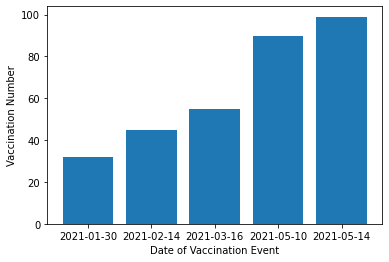

In [80]:
import matplotlib.pyplot as plt
plt.bar(x,y)
plt.xlabel("Date of Vaccination Event")
plt.ylabel("Vaccination Number")
plt.show()